### Semi-Synthetic Notebook

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from pprint import pprint

from data_dir import data_dir

# Load m1_asymptotic data, which is one directory up from data_dir
data_dir = data_dir.split("\\")[:-2]
data_dir = "\\".join(data_dir) + "\\"

pprint(data_dir)

('C:\\Users\\Adam\\OneDrive - University of Cambridge\\PhD\\Projects\\CVQKD '
 'Postselection and Security\\QPT_for_CVQKD\\data\\')


In [9]:
# Load data as pandas dataframe. We need loss vs optimal v_mod

data = pd.read_csv(data_dir + "m1_asymptotic_GBSR_vs_SR.csv", sep = " ")

data.describe()

,loss,SR_key_rate,SR_v_mod,SR_p_pass,SR_leaked_information,GBSR_key_rate,GBSR_v_mod,GBSR_p_pass,GBSR_leaked_information,GBSR_g
count,200.000000,200.000000,200.000000,200.0,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,-7.550000,0.004608,0.157965,1.0,0.989600,0.092979,0.543136,0.335143,0.689956,1.058478
std,4.333668,0.013160,0.297142,0.0,0.027502,0.035485,0.585348,0.046879,0.101616,0.052327
min,-15.000000,0.000139,0.071977,1.0,0.745549,0.068095,0.085643,0.287095,0.257783,1.020745
25%,-11.275000,0.000342,0.075341,1.0,0.992859,0.071595,0.223150,0.302777,0.658334,1.026590
50%,-7.550000,0.000904,0.084676,1.0,0.997834,0.080057,0.422926,0.324718,0.736124,1.042473
75%,-3.825000,0.002989,0.119609,1.0,0.999180,0.099233,0.625926,0.350022,0.760622,1.062193
max,-0.100000,0.129929,3.308572,1.0,0.999668,0.313925,5.348363,0.592614,0.762712,1.335127


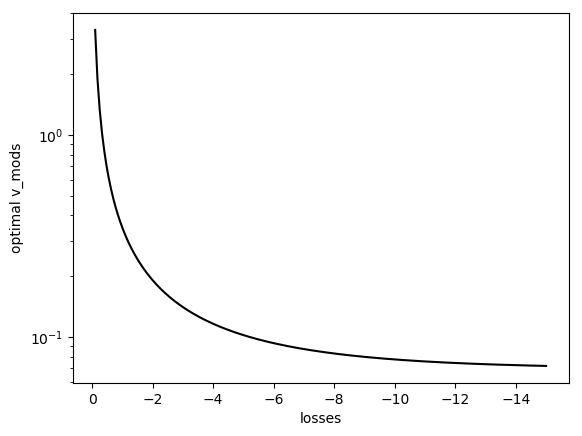

In [10]:
losses = data["loss"]
optimal_v_mods = data["SR_v_mod"]

# Plot optimal_v_mods over losses, with y log scale and x axis inverted
plt.plot(losses, optimal_v_mods, "k-")
plt.yscale("log")
plt.xlabel("losses")
plt.ylabel("optimal v_mods")
plt.gca().invert_xaxis()
plt.show()

In [11]:
# Using an attenuation coefficient on 0.2 dB/km and a 20 km link.
# We can extract the optimal v_mod for the found loss from the data, using linear interpolation. Specifically, np.interp
atten_coeff = -0.2
loss = 20.0 * atten_coeff
transmittance = 10 ** (loss / 10)

optimal_v_mod_20km = np.interp(loss, losses, optimal_v_mods)

# No excess noise (for now)
xi = 0.0

optimal_v_mod_20km

0.0719767351866987

For now, from here, as Bob's $q$ and $p$ values are highly non-Gaussian, I think it's best to proceed with synthetic data.

That is, given a (marginalised) covariance matrix
$$
\Sigma = \begin{pmatrix}
a & c \\
c & b
\end{pmatrix}
$$ which represents experimental parameters,
$$ a = V_\text{mod} + 1 $$
$$ b = (TV_\text{mod} + 1 + \xi) $$
$$ c = \sqrt{T(a^2 - 1)} $$
of which $a$ is Alice's variance, $b$ is Bob's variance and $c$ is the covariance of their data.



In [12]:
a = optimal_v_mod_20km + 1.0
b = (transmittance * optimal_v_mod_20km) + 1.0 + xi
c = np.sqrt(transmittance * (a**2 - 1.0))

cov_mat = np.array(
    (
        [a, c],
        [c, b]
    )
)

cov_mat

array([[1.07197674, 0.2436624 ],
       [0.2436624 , 1.02865445]])

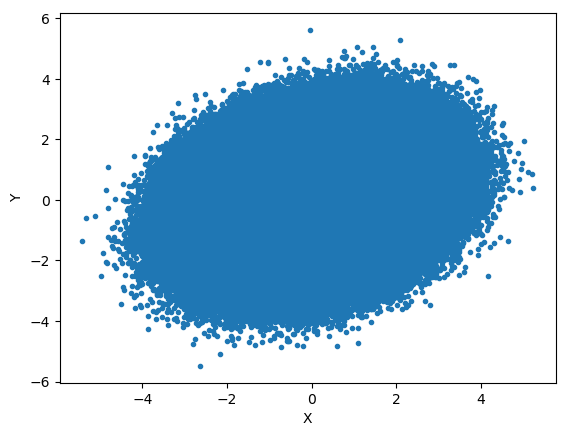

In [13]:
# Generate synthetic data by sampling from a multi-variate normal distribution.
# As many samples as those generated in experiment. TODO: Need to talk to Muataz about how many blocks and bit rate this represents.
n_samples = 5000000
rv = multivariate_normal([0.0, 0.0], cov_mat)

samples = rv.rvs(n_samples)

x_synthetic = samples[:, 0]
y_synthetic = samples[:, 1]

# Plot scatter plot of samples
plt.scatter(x_synthetic, y_synthetic, marker=".")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [14]:
# Create a dataframe from the synthetic data and include parameters
synthetic_data_df = pd.DataFrame({
    'X': x_synthetic,
    'Y': y_synthetic,
    'loss': loss,
    'optimal_v_mod_20km': optimal_v_mod_20km,
    'attenuation_coefficient': atten_coeff,
    'transmittance': transmittance,
    'xi': xi
})

# Save the dataframe to a .csv file
synthetic_data_df.to_csv(data_dir + "synthetic_data_20km_loss.csv", index=False)

###